In [1]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report,f1_score,roc_auc_score
import kds
from sklearn.preprocessing import LabelEncoder
import shap
import xgboost as xgb
import xgbfir
from catboost import CatBoostClassifier
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train = pd.read_csv('X_train.csv',sep="|")
test = pd.read_csv('X_test.csv',sep="|")
train.head()

,id,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents,target,AGE_BIN,REVOLVING_UTILIZATION_BIN,NO_TIMES_30PASTDUE_BIN,DebtRatio_BIN,MonthlyIncome_BIN,NumberOfTimes90DaysLate_BIN,NumberOfTime6089DaysPastDueNotWorse_BIN
0,99667,0.395285,52,0,2791.000000,NaN,13,0,1,0,3.0,0,49-55,0.22-0.68,0,More than 0.35,MISSING,0,0
1,40877,0.047125,67,0,0.269608,10492.0,5,0,2,0,0.0,0,More than 67,0.04-0.22,0,0-0.35,More than 5330,0,0
2,30554,0.980013,49,0,0.077280,5175.0,3,2,0,1,1.0,1,49-55,More than 0.68,0,0-0.35,0-5330,More than 0,More than 0
3,140513,0.691138,54,0,0.687868,13583.0,9,0,1,0,0.0,0,49-55,More than 0.68,0,More than 0.35,More than 5330,0,0
4,61726,0.073926,23,0,0.000703,2845.0,2,0,0,0,0.0,0,0-36,0.04-0.22,0,0-0.35,0-5330,0,0


In [3]:
features=['AGE_BIN','REVOLVING_UTILIZATION_BIN','NO_TIMES_30PASTDUE_BIN','DebtRatio_BIN','MonthlyIncome_BIN'
          ,'NumberOfTimes90DaysLate_BIN','NumberOfTime6089DaysPastDueNotWorse_BIN','target']

In [4]:
breaks = {
    'AGE_BIN' : ['0-36','36-43','43-49','49-55','55-62','62-67','More than 67']
    ,'REVOLVING_UTILIZATION_BIN' : ['0-0.04','0.04-0.22','0.22-0.68','More than 0.68']
    ,'NO_TIMES_30PASTDUE_BIN' : ['0','1','More than 1']
    ,'DebtRatio_BIN' : ['0-0.35','More than 0.35']
    ,'MonthlyIncome_BIN' : ['0-5330','MISSING','More than 5330']
    ,'NumberOfTimes90DaysLate_BIN' : ['0','More than 0']
    ,'NumberOfTime6089DaysPastDueNotWorse_BIN' : ['0','More than 0']
}

In [5]:
bins = sc.woebin(train[features],y='target',breaks_list=breaks)

[INFO] creating woe binning ...


In [6]:
train_woe = sc.woebin_ply(train[features],bins)
test_woe = sc.woebin_ply(test[features],bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [7]:
train_y = train_woe['target']
test_y = test_woe['target']
train_woe.drop(columns='target',inplace=True)
test_woe.drop(columns='target',inplace=True)
train_woe = sm.add_constant(train_woe)
test_woe = sm.add_constant(test_woe)

In [8]:
print(train_woe.shape)
print(test_woe.shape)

(105000, 8)
(45000, 8)


In [9]:
model = sm.Logit(train_y,train_woe)
lr_model = model.fit()
lr_model.summary2()

Optimization terminated successfully.
         Current function value: 0.184481
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                        Logit                     Pseudo R-squared:          0.248     
Dependent Variable:           target                    AIC:                       38756.9284
Date:                         2023-11-01 08:23          BIC:                       38833.4222
No. Observations:             105000                    Log-Likelihood:            -19370.   
Df Model:                     7                         LL-Null:                   -25765.   
Df Residuals:                 104992                    LLR p-value:               0.0000    
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               8.0000                                                         
---------------------------------------------------------------------------------------------
                                             Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------
const                                       -2.6085   0.0151 -173.2262 0.0000 -2.6380 -2.5790
MonthlyIncome_BIN_woe                        0.4276   0.0568    7.5342 0.0000  0.3164  0.5388
REVOLVING_UTILIZATION_BIN_woe                0.6200   0.0148   41.7604 0.0000  0.5909  0.6491
DebtRatio_BIN_woe                            1.1175   0.1067   10.4782 0.0000  0.9085  1.3265
NumberOfTimes90DaysLate_BIN_woe              0.5553   0.0134   41.5066 0.0000  0.5290  0.5815
NO_TIMES_30PASTDUE_BIN_woe                   0.5272   0.0153   34.5255 0.0000  0.4972  0.5571
NumberOfTime6089DaysPastDueNotWorse_BIN_woe  0.4068   0.0167   24.3348 0.0000  0.3740  0.4396
AGE_BIN_woe                                  0.4690   0.0311   15.1021 0.0000  0.4082  0.5299
=============================================================================================

"""

In [10]:
test['prediction'] = lr_model.predict(test_woe)

ROC 0.8533197290238668
LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.136,0.858,0.348,4500.0,1599.0,2901.0,300.8,3008,35.533,4500.0,1599.0,3008,2901.0,10.0,53.158,100.0,6.908,46.250,5.316
1,2,0.082,0.136,0.101,4500.0,512.0,3988.0,300.8,0,11.378,9000.0,2111.0,3008,6889.0,20.0,70.180,100.0,16.406,53.774,3.509
2,3,0.049,0.082,0.063,4500.0,323.0,4177.0,300.8,0,7.178,13500.0,2434.0,3008,11066.0,30.0,80.918,100.0,26.353,54.565,2.697
3,4,0.035,0.049,0.042,4500.0,201.0,4299.0,300.8,0,4.467,18000.0,2635.0,3008,15365.0,40.0,87.600,100.0,36.590,51.010,2.190
4,5,0.025,0.035,0.030,4500.0,136.0,4364.0,300.8,0,3.022,22500.0,2771.0,3008,19729.0,50.0,92.121,100.0,46.983,45.138,1.842
5,6,0.021,0.025,0.023,4500.0,76.0,4424.0,300.8,0,1.689,27000.0,2847.0,3008,24153.0,60.0,94.648,100.0,57.518,37.130,1.577
6,7,0.017,0.021,0.019,4500.0,57.0,4443.0,300.8,0,1.267,31500.0,2904.0,3008,28596.0,70.0,96.543,100.0,68.099,28.444,1.379
7,8,0.014,0.017,0.015,4500.0,51.0,4449.0,300.8,0,1.133,36000.0,2955.0,3008,33045.0,80.0,98.238,100.0,78.694,19.544,1.228
8,9,0.011,0.014,0.012,4500.0,32.0,4468.0,300.8,0,0.711,40500.0,2987.0,3008,37513.0,90.0,99.302,100.0,89.334,9.968,1.103
9,10,0.008,0.011,0.009,4500.0,21.0,4479.0,300.8,0,0.467,45000.0,3008.0,3008,41992.0,100.0,100.000,100.0,100.000,0.000,1.000


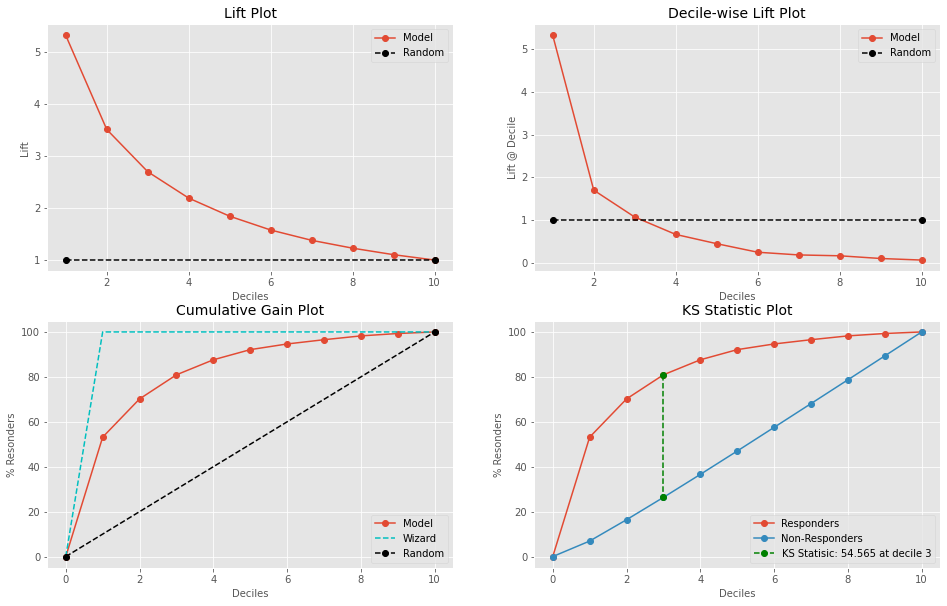

In [11]:
print("ROC",roc_auc_score(test['target'],test['prediction']))
kds.metrics.report(test['target'],test['prediction'],plot_style='ggplot')

In [12]:
train_woe.columns

Index(['const', 'MonthlyIncome_BIN_woe', 'REVOLVING_UTILIZATION_BIN_woe',
       'DebtRatio_BIN_woe', 'NumberOfTimes90DaysLate_BIN_woe',
       'NO_TIMES_30PASTDUE_BIN_woe',
       'NumberOfTime6089DaysPastDueNotWorse_BIN_woe', 'AGE_BIN_woe'],
      dtype='object')

In [13]:
train['target'].value_counts()
97982/7018

13.961527500712453

In [14]:
varcount = 7
factor = 10/np.log(2)
offset = 50 - (factor * np.log(5))

In [15]:
lr_model.params

const                                         -2.608480
MonthlyIncome_BIN_woe                          0.427604
REVOLVING_UTILIZATION_BIN_woe                  0.619956
DebtRatio_BIN_woe                              1.117500
NumberOfTimes90DaysLate_BIN_woe                0.555255
NO_TIMES_30PASTDUE_BIN_woe                     0.527151
NumberOfTime6089DaysPastDueNotWorse_BIN_woe    0.406802
AGE_BIN_woe                                    0.469050
dtype: float64

In [16]:
intercept = lr_model.params['const']
NO_TIMES_30PASTDUE_coef = lr_model.params['NO_TIMES_30PASTDUE_BIN_woe']
DebtRatio_coef = lr_model.params['DebtRatio_BIN_woe']
AGE_BIN_coef = lr_model.params['AGE_BIN_woe']
REVOLVING_UTILIZATION_coef = lr_model.params['REVOLVING_UTILIZATION_BIN_woe']  
NumberOfTime6089DaysPastDueNotWorse_coef = lr_model.params['NumberOfTime6089DaysPastDueNotWorse_BIN_woe']
NumberOfTimes90DaysLate_coef = lr_model.params['NumberOfTimes90DaysLate_BIN_woe']
MonthlyIncome_coef = lr_model.params['MonthlyIncome_BIN_woe']

In [17]:
#bins

In [18]:
print(-(bins['NO_TIMES_30PASTDUE_BIN']['woe'][0] * NO_TIMES_30PASTDUE_coef + intercept / 7) * factor + offset / 7)
print(-(bins['NO_TIMES_30PASTDUE_BIN']['woe'][1] * NO_TIMES_30PASTDUE_coef + intercept / 7) * factor + offset / 7)
print(-(bins['NO_TIMES_30PASTDUE_BIN']['woe'][2] * NO_TIMES_30PASTDUE_coef + intercept / 7) * factor + offset / 7)

13.322329519638334
2.3328433470337564
-5.264052399429908


In [19]:
print(-(bins['DebtRatio_BIN']['woe'][0] * DebtRatio_coef + intercept / 7) * factor + offset / 7)
print(-(bins['DebtRatio_BIN']['woe'][1] * DebtRatio_coef + intercept / 7) * factor + offset / 7)

11.586137342696198
7.247429120062957


In [20]:
print(-(bins['AGE_BIN']['woe'][0] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][1] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][2] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][3] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][4] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][5] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)
print(-(bins['AGE_BIN']['woe'][6] * AGE_BIN_coef + intercept / 7) * factor + offset / 7)

5.3428689781010394
6.916416852851022
7.785302516490825
8.334165509046809
11.025259923484152
13.39909051720785
16.64337770397314


In [21]:
print(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][0] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7)
print(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][1] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7)
print(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][2] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7)
print(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][3] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7)

21.474742913506297
18.7311146408097
9.881120844141677
-1.7752732373405138


In [22]:
print(-(bins['NumberOfTime6089DaysPastDueNotWorse_BIN']['woe'][0] * NumberOfTime6089DaysPastDueNotWorse_coef + intercept / 7) * factor + offset / 7)
print(-(bins['NumberOfTime6089DaysPastDueNotWorse_BIN']['woe'][1] * NumberOfTime6089DaysPastDueNotWorse_coef + intercept / 7) * factor + offset / 7)

10.891455578990794
-3.006426154203063


In [23]:
print(-(bins['NumberOfTimes90DaysLate_BIN']['woe'][0] * NumberOfTimes90DaysLate_coef + intercept / 7) * factor + offset / 7)
print(-(bins['NumberOfTimes90DaysLate_BIN']['woe'][1] * NumberOfTimes90DaysLate_coef + intercept / 7) * factor + offset / 7)

12.35615320057643
-9.26481186145661


In [24]:
print(-(bins['MonthlyIncome_BIN']['woe'][0] * MonthlyIncome_coef + intercept / 7) * factor + offset / 7)
print(-(bins['MonthlyIncome_BIN']['woe'][1] * MonthlyIncome_coef + intercept / 7) * factor + offset / 7)
print(-(bins['MonthlyIncome_BIN']['woe'][2] * MonthlyIncome_coef + intercept / 7) * factor + offset / 7)

7.502477444692746
10.315839433453288
10.70900368999615


In [25]:
(-(bins['MonthlyIncome_BIN']['woe'][2] * MonthlyIncome_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NumberOfTimes90DaysLate_BIN']['woe'][0] * NumberOfTimes90DaysLate_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NumberOfTime6089DaysPastDueNotWorse_BIN']['woe'][0] * NumberOfTime6089DaysPastDueNotWorse_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][0] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['AGE_BIN']['woe'][6] * AGE_BIN_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NO_TIMES_30PASTDUE_BIN']['woe'][0] * NO_TIMES_30PASTDUE_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['DebtRatio_BIN']['woe'][0] * DebtRatio_coef + intercept / 7) * factor + offset / 7)

96.98319994937734

In [26]:
(-(bins['MonthlyIncome_BIN']['woe'][0] * MonthlyIncome_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NumberOfTimes90DaysLate_BIN']['woe'][1] * NumberOfTimes90DaysLate_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NumberOfTime6089DaysPastDueNotWorse_BIN']['woe'][1] * NumberOfTime6089DaysPastDueNotWorse_coef + intercept / 7) * factor + offset / 7)  +\
(-(bins['REVOLVING_UTILIZATION_BIN']['woe'][3] * REVOLVING_UTILIZATION_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['AGE_BIN']['woe'][0] * AGE_BIN_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['DebtRatio_BIN']['woe'][1] * DebtRatio_coef + intercept / 7) * factor + offset / 7) +\
(-(bins['NO_TIMES_30PASTDUE_BIN']['woe'][2] * NO_TIMES_30PASTDUE_coef + intercept / 7) * factor + offset / 7)

0.7822118904266464

In [32]:
test['Monthly_Income_Points'] = np.where(test['monthlyincome'].isna(),10.32
                                         ,np.where(test['monthlyincome']<=5330,7.5
                                                        ,np.where(test['monthlyincome'] > 5330,10.71,7.5)))

In [37]:
test['revolvingutilizationofunsecuredlines_points'] = np.where(test['revolvingutilizationofunsecuredlines']<0.04,21.47
                                                              ,np.where(test['revolvingutilizationofunsecuredlines']<0.22,18.73
                                                                       ,np.where(test['revolvingutilizationofunsecuredlines']<0.68,9.88
                                                                                ,np.where(test['revolvingutilizationofunsecuredlines']>=0.68,-1.78,-1.78))))

In [40]:
test['numberoftime3059dayspastduenotworse_points'] = np.where(test['numberoftime3059dayspastduenotworse'] ==0,13.32
                                                             ,np.where(test['numberoftime3059dayspastduenotworse'] == 1,2.33
                                                                      ,np.where(test['numberoftime3059dayspastduenotworse']>1,-5.26,-5.26)))

In [42]:
test['age_points'] = np.where(test['age']<36,5.34
                             ,np.where(test['age']<43,6.92
                                      ,np.where(test['age']<49,7.79
                                               ,np.where(test['age']<55,8.33
                                                        ,np.where(test['age']<62,11.03
                                                                 ,np.where(test['age'] < 67,13.4
                                                                          ,np.where(test['age']>=67,16.64,5.34)))))))

In [45]:
test['debtratio_points'] = np.where(test['debtratio']<0.35,11.59
                                   ,np.where(test['debtratio']>=0.35,7.25,7.25))

In [47]:
test['numberoftime6089dayspastduenotworse_points'] = np.where(test['numberoftime6089dayspastduenotworse']==0,10.89
                                                             ,-3.00)

In [49]:
test['numberoftimes90dayslate_points'] = np.where(test['numberoftimes90dayslate'] ==0 ,12.36,-9.26)

In [50]:
test['score'] = test['Monthly_Income_Points'] + test['revolvingutilizationofunsecuredlines_points'] +\
                    test['numberoftime3059dayspastduenotworse_points'] + test['age_points'] +\
                    test['debtratio_points'] + test['numberoftime6089dayspastduenotworse_points'] +\
                    test['numberoftimes90dayslate_points']

In [52]:
print(min(test['score']))
print(max(test['score']))

0.7900000000000009
96.98


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,91.37,96.98,94.080,4500.0,21.0,4479.0,300.8,3008,0.467,4500.0,21.0,3008,4479.0,10.0,0.698,100.0,10.666,-9.968,0.070
1,2,88.63,91.37,89.925,4500.0,29.0,4471.0,300.8,0,0.644,9000.0,50.0,3008,8950.0,20.0,1.662,100.0,21.314,-19.652,0.083
2,3,85.39,88.63,86.720,4500.0,54.0,4446.0,300.8,0,1.200,13500.0,104.0,3008,13396.0,30.0,3.457,100.0,31.901,-28.444,0.115
3,4,82.47,85.39,83.851,4500.0,57.0,4443.0,300.8,0,1.267,18000.0,161.0,3008,17839.0,40.0,5.352,100.0,42.482,-37.130,0.134
4,5,79.71,82.47,80.826,4500.0,75.0,4425.0,300.8,0,1.667,22500.0,236.0,3008,22264.0,50.0,7.846,100.0,53.020,-45.174,0.157
5,6,74.60,79.71,76.865,4500.0,137.0,4363.0,300.8,0,3.044,27000.0,373.0,3008,26627.0,60.0,12.400,100.0,63.410,-51.010,0.207
6,7,69.53,74.60,71.880,4500.0,200.0,4300.0,300.8,0,4.444,31500.0,573.0,3008,30927.0,70.0,19.049,100.0,73.650,-54.601,0.272
7,8,61.55,69.53,65.823,4500.0,324.0,4176.0,300.8,0,7.200,36000.0,897.0,3008,35103.0,80.0,29.820,100.0,83.594,-53.774,0.373
8,9,53.43,61.55,58.396,4500.0,512.0,3988.0,300.8,0,11.378,40500.0,1409.0,3008,39091.0,90.0,46.842,100.0,93.092,-46.250,0.520
9,10,0.79,53.43,36.933,4500.0,1599.0,2901.0,300.8,0,35.533,45000.0,3008.0,3008,41992.0,100.0,100.000,100.0,100.000,0.000,1.000


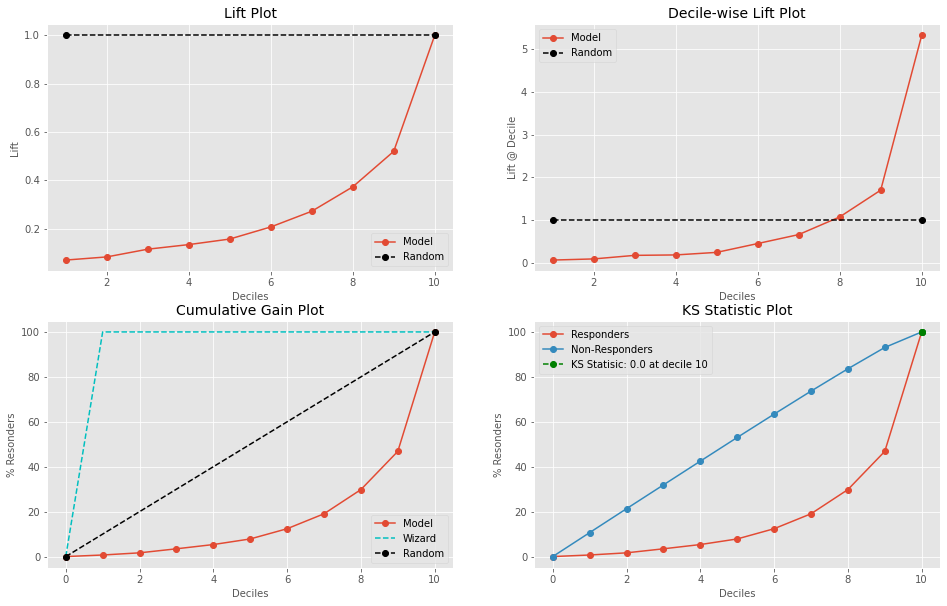

In [56]:
kds.metrics.report(test['target'],test['score'],plot_style='ggplot')

In [63]:
print(2901/1599)
print(3988/512)
print(4176/316)
print(4300/200)

1.8142589118198875
7.7890625
13.215189873417721
21.5
